In [1]:
!mkdir /content/samples/
!cd /content/drive/MyDrive/ && cp vk-made-ocr.zip /content/vk-made-ocr.zip && unzip /content/vk-made-ocr.zip -d /content/samples

Streaming output truncated to the last 5000 lines.
  inflating: /content/samples/train/train/955.jpg  
  inflating: /content/samples/train/train/9550.jpg  
  inflating: /content/samples/train/train/95500.jpg  
  inflating: /content/samples/train/train/95501.jpg  
  inflating: /content/samples/train/train/95502.jpg  
  inflating: /content/samples/train/train/95503.jpg  
  inflating: /content/samples/train/train/95504.jpg  
  inflating: /content/samples/train/train/95505.jpg  
  inflating: /content/samples/train/train/95506.jpg  
  inflating: /content/samples/train/train/95507.jpg  
  inflating: /content/samples/train/train/95508.jpg  
  inflating: /content/samples/train/train/95509.jpg  
  inflating: /content/samples/train/train/9551.jpg  
  inflating: /content/samples/train/train/95510.jpg  
  inflating: /content/samples/train/train/95511.jpg  
  inflating: /content/samples/train/train/95512.jpg  
  inflating: /content/samples/train/train/95513.jpg  
  inflating: /content/samples/train

In [2]:
!pip install livelossplot --quiet

In [1]:
TEST_SPLIT = 0.1
ROOT = "/content/samples/train/train"

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import glob
import os
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from livelossplot import PlotLosses

In [38]:
class CaptchaDataset(Dataset):

    def __init__(self, root, csv, label2idx, train=True, transforms=None, filter=True):
        self.root = root
        self.csv = pd.read_csv(csv)
        self.train = train
        end = int(len(self.csv) * (1 - TEST_SPLIT))
        if train:
            self.csv = self.csv.iloc[:end]
        else:
            self.csv = self.csv.iloc[end:]
        self.transforms = transforms

    def __len__(self,):
        return len(self.csv)
      
    def __getitem__(self, idx):
        image_name  = self.csv.iloc[idx]['Id']
        image = Image.open(os.path.join(self.root, image_name)).convert("RGB")
        if self.transforms is not None:
            image = self.transforms(image)
        # if self.train:
        transcript = self.csv.iloc[idx]['Expected']
        transcript = str(transcript).lower()
        labels = []
        for idx, char in enumerate(transcript):
            if char in label2idx:
                labels.append(label2idx[char])
            else:
                labels.append(label2idx["#"])

        labels = torch.Tensor(labels)

        return {"images": image, "labels": labels, "target_length": len(transcript), "text": transcript}
        # else:
        #     return {"images": image}


In [26]:
from collections import Counter

labels = pd.read_csv("/content/samples/train_labels.csv")['Expected']
labels_letters = []
for label in labels:
    labels_letters.extend([letter for letter in str(label).lower()])
counter_dict = Counter(labels_letters)
counter_dict = counter_dict.most_common(100)

In [27]:
def create_dict(counter_dict):
    tokens = ["#"]
    dict_ = {"-": 0, "#": 1}
    counter = 2
    for label in labels:
        transcript = str(label).lower()
        for char, num in counter_dict:
            if not char in dict_:
                dict_[char] = counter
                counter += 1
                tokens.append(char)
    tokens.append("|")
    return dict_, counter, tokens

label2idx, dict_len, tokens = create_dict(counter_dict)

In [28]:
def collate_fn(batch):
    images, seqs, seq_lens, texts = [], [], [], []
    for item in batch:
        images.append(item["images"].float())
        seqs.extend(item["labels"])
        seq_lens.append(item["target_length"])
        texts.append(item["text"])
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"images": images, "labels": seqs, "target_length": seq_lens, "text": texts}
    return batch

In [29]:
train_transforms = transforms.Compose([transforms.Resize((64, 320)),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transforms = transforms.Compose([transforms.Resize((64, 320)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                                      

train_dataset = CaptchaDataset(ROOT, "/content/samples/train_labels.csv", label2idx, True, train_transforms)
test_dataset = CaptchaDataset(ROOT, "/content/samples/train_labels.csv", label2idx, False, test_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)


In [31]:
def levenshteinDistance(str1, str2):
    m = len(str1)
    n = len(str2)
    d = [[i] for i in range(1, m + 1)]   
    d.insert(0, list(range(0, n + 1)))
    for j in range(1, n + 1):
        for i in range(1, m + 1):
            if str1[i - 1] == str2[j - 1]:
                substitutionCost = 0
            else:
                substitutionCost = 1
            d[i].insert(j, min(d[i - 1][j] + 1,
                               d[i][j - 1] + 1,
                               d[i - 1][j - 1] + substitutionCost))
    return d[-1][-1]

def calc_cer(str1, str2):
    return levenshteinDistance(str1, str2) / len(str1)

In [32]:
abc = tokens

In [33]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, Sequential, Conv2d, AvgPool2d, GRU, Linear
from torch.nn.functional import ctc_loss, log_softmax
from torchvision import models


class FeatureExtractor(Module):
    
    def __init__(self, input_size=(64, 320), output_len=20):
        super(FeatureExtractor, self).__init__()
        
        h, w = input_size
        resnet = getattr(models, 'resnet34')(pretrained=True)
        self.cnn = Sequential(*list(resnet.children())[:-2])
        
        self.pool = AvgPool2d(kernel_size=(h // 32, 1))        
        self.proj = Conv2d(w // 32, output_len, kernel_size=1)
  
        self.num_output_features = self.cnn[-1][-1].bn2.num_features    
    
    def apply_projection(self, x):
        """Use convolution to increase width of a features.
        
        Args:
            - x: Tensor of features (shaped B x C x H x W).
            
        Returns:
            New tensor of features (shaped B x C x H x W').
        """
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        
        return x
   
    def forward(self, x):
        # Apply conv layers
        features = self.cnn(x)
        
        # Pool to make height == 1
        features = self.pool(features)
        
        # Apply projection to increase width
        features = self.apply_projection(features)
        
        return features


class SequencePredictor(Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3, bidirectional=False):
        super(SequencePredictor, self).__init__()
        
        self.num_classes = num_classes        
        self.rnn = GRU(input_size=input_size,
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       dropout=dropout,
                       bidirectional=bidirectional)
        
        fc_in = hidden_size if not bidirectional else 2 * hidden_size
        self.fc = Linear(in_features=fc_in,
                         out_features=num_classes)
    
    def _init_hidden(self, batch_size):
        """Initialize new tensor of zeroes for RNN hidden state.
        
        Args:
            - batch_size: Int size of batch
            
        Returns:
            Tensor of zeros shaped (num_layers * num_directions, batch, hidden_size).
        """
        num_directions = 2 if self.rnn.bidirectional else 1
        
        # YOUR CODE HERE
        h = torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)
        # END OF YOUR CODE
        
        return h
        
    def _reshape_features(self, x):
        """Change dimensions of x to fit RNN expected input.
        
        Args:
            - x: Tensor x shaped (B x (C=1) x H x W).
        
        Returns:
            New tensor shaped (W x B x H).
        """
        
        # YOUR CODE HERE
        x = x.squeeze(1)
        x = x.permute(2, 0, 1)
        # END OF YOUR CODE
        
        return x
    
    def forward(self, x):
        x = self._reshape_features(x)
        
        batch_size = x.size(1)
        h_0 = self._init_hidden(batch_size)
        h_0 = h_0.to(x.device)
        x, h = self.rnn(x, h_0)
        
        x = self.fc(x)
        return x


class CRNN(Module):
    
    def __init__(self, alphabet=abc,
                 cnn_input_size=(64, 320), cnn_output_len=20,
                 rnn_hidden_size=128, rnn_num_layers=2, rnn_dropout=0.3, rnn_bidirectional=False):
        super(CRNN, self).__init__()
        self.alphabet = alphabet
        self.features_extractor = FeatureExtractor(input_size=cnn_input_size, output_len=cnn_output_len)
        self.sequence_predictor = SequencePredictor(input_size=self.features_extractor.num_output_features,
                                                    hidden_size=rnn_hidden_size, num_layers=rnn_num_layers,
                                                    num_classes=len(alphabet)+1, dropout=rnn_dropout,
                                                    bidirectional=rnn_bidirectional)
    
    def forward(self, x):
        features = self.features_extractor(x)
        sequence = self.sequence_predictor(features)
        return sequence


In [34]:
def pred_to_string(pred, abc):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([abc[c] for c in out])
    return out

def decode(pred, abc):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], abc))
    return outputs

In [35]:
model = CRNN()
model.cuda();

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


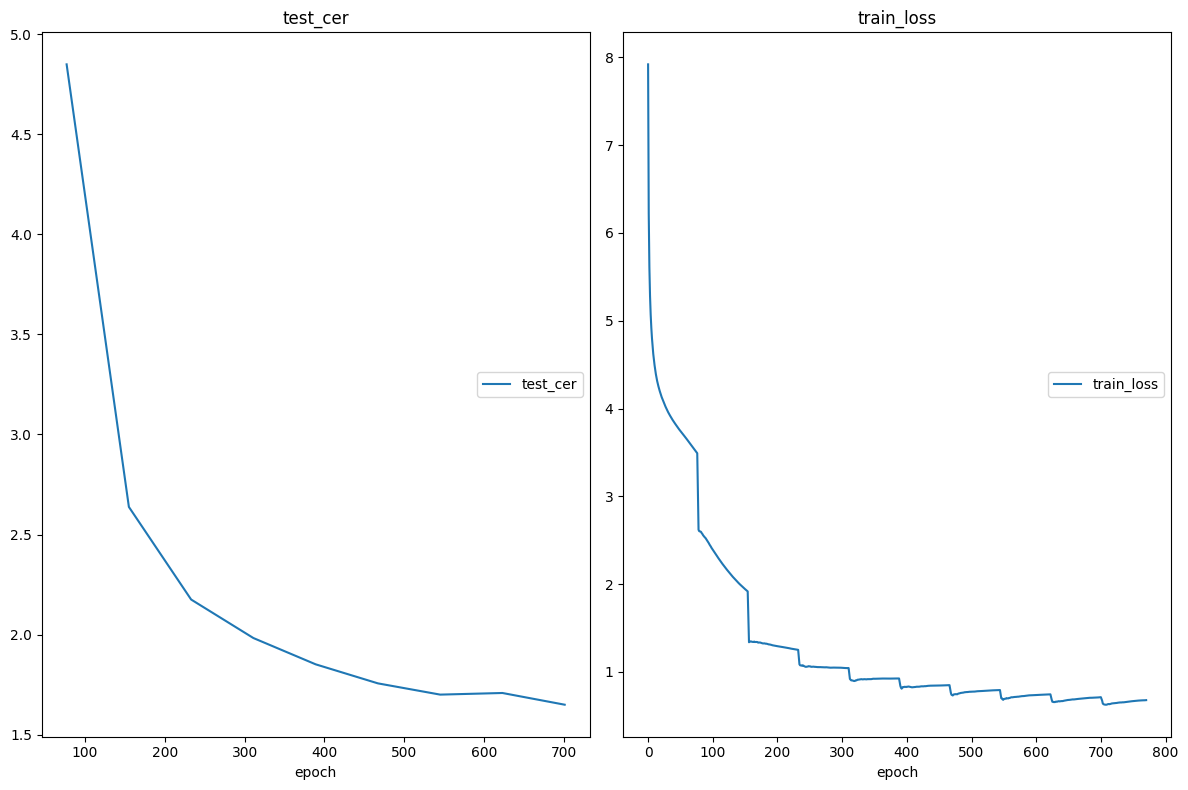

test_cer
	test_cer         	 (min:    1.650, max:    4.849, cur:    1.650)
train_loss
	train_loss       	 (min:    0.628, max:    7.918, cur:    0.679)


KeyboardInterrupt: ignored

In [36]:
import matplotlib.pyplot as plt

epochs = 10

criterion = nn.CTCLoss(zero_infinity=True)
#criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-4)

plotlosses = PlotLosses()

min_cer = 10.0
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()

        input, labels = batch["images"], batch["labels"]
        input = input.cuda()
        labels = labels.long().cuda()
        preds = model(input).log_softmax(2)
        seq_lens_pred = torch.Tensor([preds.size(0)] * preds.size(1)).int()
        loss = criterion(preds, labels, seq_lens_pred, batch['target_length'])
        loss.backward()

        optimizer.step()
        running_loss += loss.detach().cpu().item()
        if idx % 50 == 49:
            mean_loss = running_loss / (idx + 1)
            plotlosses.update({
                'train_loss': mean_loss,
            })
            plotlosses.send()
    
    model.eval()
    running_cer = 0.0
    for batch in test_dataloader:
        input, text = batch["images"], batch["text"]

        input = input.cuda()

        preds = model(input.cuda()).cpu().detach()
        texts_pred = decode(preds, tokens)
        if len(texts_pred):
            cer = levenshteinDistance(text[0], texts_pred[0])
        else:
            cer = len(text[0])
        running_cer += cer
    
    mean_cer = running_cer / len(test_dataloader)
    if mean_cer < min_cer:
        torch.save(model.state_dict(), "/content/best_ocr.pth")
        min_cer = mean_cer

    plotlosses.update({
        'test_cer': mean_cer,
    })
    plotlosses.send()

In [37]:
model.load_state_dict(torch.load("/content/best_ocr.pth"))

<All keys matched successfully>

In [40]:
def collate_fn_test(batch):
    images, seqs, seq_lens, texts = [], [], [], []
    for item in batch:
        images.append(item["images"].float())
    images = torch.stack(images)
    batch = {"images": images}
    return batch

In [41]:
test_transforms = transforms.Compose([transforms.Resize((64, 320)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                                      

test_final_dataset = CaptchaDataset(ROOT, "/content/samples/sample_submission.csv", label2idx, False, test_transforms)

test_dataloader = DataLoader(test_final_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn_test)

In [82]:
def pred_image(image_path):
    image = Image.open(image_path)
    image_tensor = test_transforms(image).unsqueeze(0)

    preds = model(image_tensor.cuda()).cpu().detach()
    texts_pred = decode(preds, tokens)
    return texts_pred[0]

def pred_image_show(image_path):
    image = Image.open(image_path)
    image_tensor = test_transforms(image).unsqueeze(0)

    preds = model(image_tensor.cuda()).cpu().detach()
    texts_pred = decode(preds, tokens)
    plt.imshow(image)
    print(texts_pred[0])

In [87]:
model.eval()
sample_submission = pd.read_csv("/content/samples/sample_submission.csv")
counter = 0
for row in sample_submission.iterrows():
    path = row[1]['Id']
    text = pred_image(os.path.join("/content/samples/test/test", path))
    row[1]['Predicted'] = text
    counter += 1
    print(counter)

sample_submission.to_csv("/content/result.csv", index=False)

Streaming output truncated to the last 5000 lines.
48000
48001
48002
48003
48004
48005
48006
48007
48008
48009
48010
48011
48012
48013
48014
48015
48016
48017
48018
48019
48020
48021
48022
48023
48024
48025
48026
48027
48028
48029
48030
48031
48032
48033
48034
48035
48036
48037
48038
48039
48040
48041
48042
48043
48044
48045
48046
48047
48048
48049
48050
48051
48052
48053
48054
48055
48056
48057
48058
48059
48060
48061
48062
48063
48064
48065
48066
48067
48068
48069
48070
48071
48072
48073
48074
48075
48076
48077
48078
48079
48080
48081
48082
48083
48084
48085
48086
48087
48088
48089
48090
48091
48092
48093
48094
48095
48096
48097
48098
48099
48100
48101
48102
48103
48104
48105
48106
48107
48108
48109
48110
48111
48112
48113
48114
48115
48116
48117
48118
48119
48120
48121
48122
48123
48124
48125
48126
48127
48128
48129
48130
48131
48132
48133
48134
48135
48136
48137
48138
48139
48140
48141
48142
48143
48144
48145
48146
48147
48148
48149
48150
48151
48152
48153
48154
48155
48156
48157
4

neto


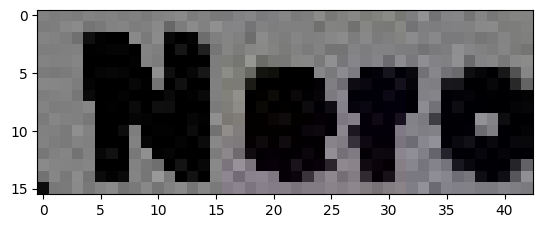

In [81]:
pred_image("/content/samples/test/test/30.jpg")